# Producing rainfall profiles for Lin Dyke
Synthetic summary profiles have been produced for extreme UK rain storms, which describe the intensity of rainfall over time.  
This work tests the extent to which use of these different profiles affects the flooding outcomes.  
The profiles are tested using a 2D Hec-Ras model of the Lin Dyke catchments in east Leeds.  

A 6 hour duration, 100 year return period event is initially focussed on (with the idea that if differences between profiles are identified at this return period then further investigation will be made of whether differences are also present for less rare events). The total rainfall volume associated with a 6hr, 1-in-100 year event in the Lin Dyke catchment  is extracted from ReFH2 (and is 59.98mm).

The Hec-Ras model requires a rainfall input which describes the rainfall depth at each minute during the rain storm event duration. The summary profiles describe the proportion of the total rainfall volume which falls in each of 12 time steps in any event duration. To use these to generate a rainfall input in the required format for a particular cluster:
* Extract the information for just that cluster, for the correct duration bins 
* For each of the 12 time steps, multiply the proportion of rain found in this timestep by the total event rainfall (59.98mm) to get the total rainfall depth which should fall in this time step
* In the case of a 6hr duration event, each of the 12 timesteps is 30 minutes long. The total rainfall depth falling in that 30 minute period is assumed to fall at a constant rate during that 30 minute interval. And so each minute within the interval is assigned a rainfall depth of 1/30th of the time step total
* The cumulative rainfall depth at each minute, and rainfall rate in each minute is also calculated

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import math

import sys
sys.path.insert(1, '../')

from CreateEvents_functions import *

## Define total event rainfall for 6h duration, 100 year return period event in Lin Dyke

In [2]:
total_event_rainfall = 59.98

## Read in synthetic summary profiles

In [114]:
# Read in profiles
profiles = pd.read_csv("kmeans_15clustersPerDur.csv")
# Just keep prain (proportion of rainfall in each timestep)
profiles = profiles[profiles['Variable'] == 'prain']

## Calculate the rainfall depth in each minute for each of 15 clusters
In the case of a 6hr duration event, each of the 12 timesteps is 30 minutes long. The total rainfall depth falling in that 30 minute period is assumed to fall at a constant rate during that 30 minute interval. And so each minute within the interval is assigned a rainfall depth of 1/30th of the time step total.

##### Test for one cluster

In [115]:
one_cluster = get_one_cluster_one_variable(profiles, 9,'[2:10 - 6:45) hr' )
one_cluster = find_rainfall_depth_each_min(one_cluster, 59.98 )
one_cluster = add_cumulative_values(one_cluster)
one_cluster.head()

,minute,rainfall_depth_this_min,cumulative_rainfall_this_min,rainfall_rate
0,1,0.078433,0.078433,4.705973
1,2,0.078433,0.156866,4.705973
2,3,0.078433,0.235299,4.705973
3,4,0.078433,0.313732,4.705973
4,5,0.078433,0.392164,4.705973


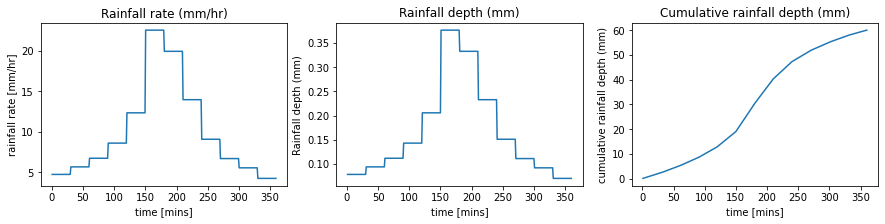

In [111]:
plot_rainfall_depth_each_min(one_cluster)

##### Produce similar outputs for each of the 15 clusters for a 6hr duration event

In [133]:
clusters_rainfall_data_ls = []
for cluster_number in range(1,16):
    one_cluster = get_one_cluster_one_variable(profiles, cluster_number,'[2:10 - 6:45) hr' )
    one_cluster = find_rainfall_depth_each_min(one_cluster, 59.98 )
    one_cluster = add_cumulative_values(one_cluster)
    one_cluster.to_csv("LinDykeProfiles/6hr_100yrRP/cluster{}.csv".format(cluster_number), index = False)
    clusters_rainfall_data_ls.append(one_cluster)

## Plot the rainfall depth in each minute for each of the 15 clusters

Text(0.09, 0.5, 'Depth (mm)')

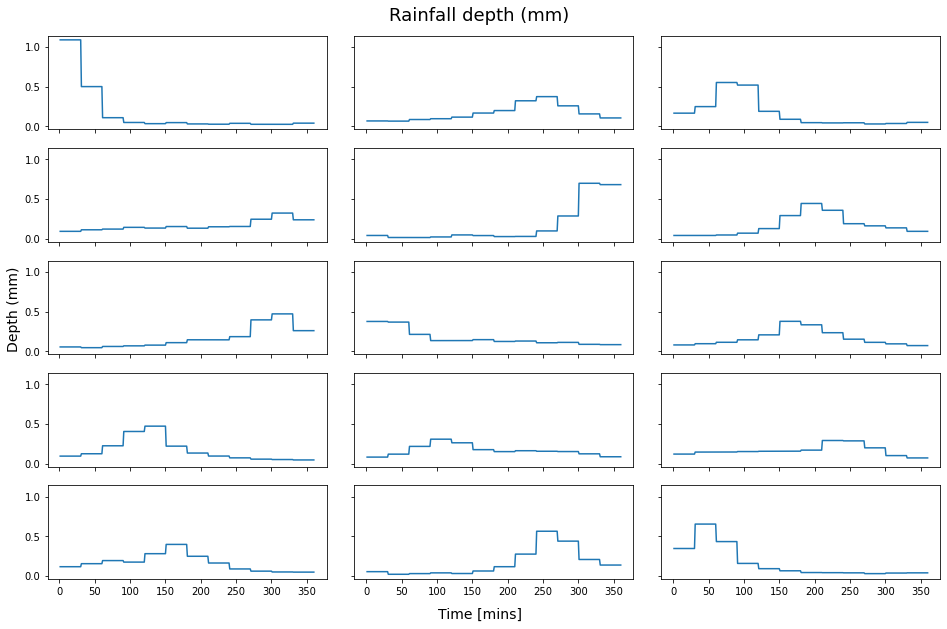

In [170]:
fig, axs = plt.subplots(nrows=5, ncols=3, figsize =(16,10), sharey=True, sharex = True)
plt.subplots_adjust(wspace=0.1)
fig.suptitle("Rainfall depth (mm)", fontsize=18, y=0.92)

# loop through tickers and axes
for clusters_rainfall_data, ax in zip(clusters_rainfall_data_ls, axs.ravel()):
    ax.plot(clusters_rainfall_data['minute'], clusters_rainfall_data['rainfall_depth_this_min'])
fig.text(0.5, 0.07, 'Time [mins]', ha='center', fontsize =14)
fig.text(0.09, 0.5, "Depth (mm)", va='center', rotation='vertical', fontsize =14)

## Approach for making single peaked profiles according to FEH
### Find the accumulation/rate associated with each minute in a 6h profile 

In [67]:
# Paramters (altho these all relate to multiple peaks think we still have to specify) 
N_subpeaks= 3
total_duration_minutes= 6 * 60
subpeak_duration_minutes=total_duration_minutes/6
# Find accumulation and rate
accum, rate= calc_rainfall_curves('single-peak',total_event_rainfall,total_duration_minutes,N_subpeaks,subpeak_duration_minutes)
# Construct as dataframe
df = pd.DataFrame({"minute": np.array(range(total_duration_minutes)),
                   'rainfall_rate':rate,
                   'rainfall_depth_this_min':rate/60,
                   'cumulative_rainfall_this_min': accum[1:]})   

### Plot the rainfall rate, depth and accumulations

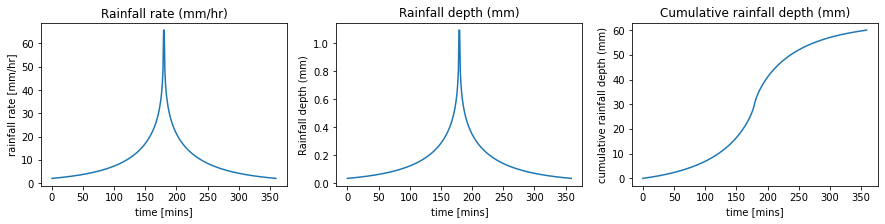

In [47]:
plot_rainfall_depth_each_min(df)

## Plot the cumulative rainfall depth for all profiles + FEH profile

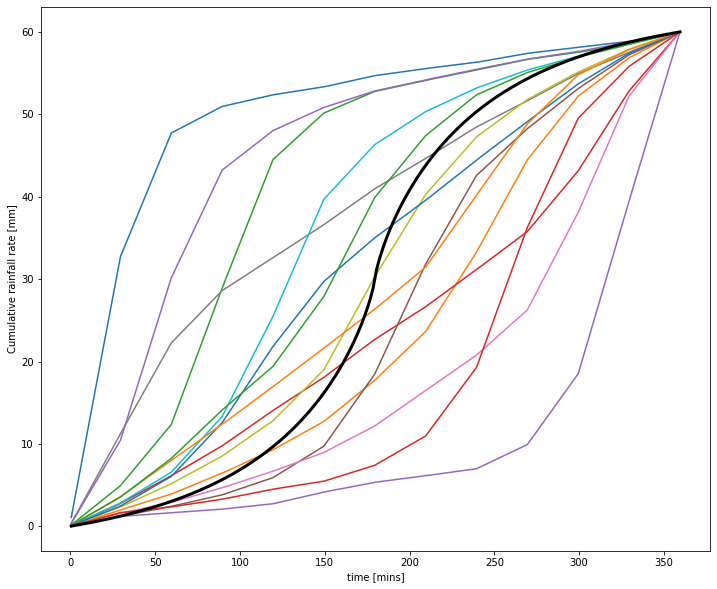

In [96]:
fig, ax = plt.subplots(figsize =(12,10))
for cluster_number in range(1,16):
    cluster = find_rainfall_depth_each_min(profiles,total_event_rainfall, cluster_number,"[2:10 - 6:45) hr" )
    ax.plot(np.array(range(360))+0.5,cluster['cumulative_rainfall_this_min'])
    ax.set_xlabel('time [mins]')
    ax.set_ylabel('Cumulative rainfall rate [mm]')
ax.plot(np.array(range(360))+0.5,df['cumulative_rainfall_this_min'], color = 'black', linewidth = 3)    

## Plot rainfall depth in each minute for each of the 15 clusters + FEH single-peak profile

Text(0.09, 0.5, 'Depth (mm)')

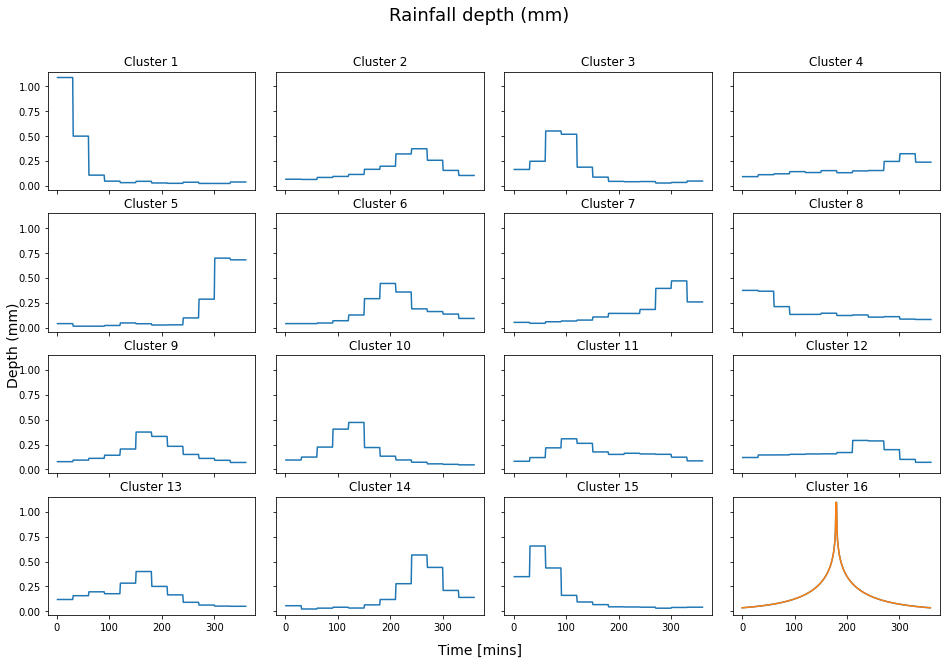

In [274]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize =(16,10), sharey=True, sharex = True)
plt.subplots_adjust(wspace=0.1)
fig.suptitle("Rainfall depth (mm)", fontsize=18, y=0.97)

clusters_and_feh_ls = clusters_rainfall_data_ls.copy()
clusters_and_feh_ls.insert(0, df)

# loop through tickers and axes
for num, clusters_rainfall_data in enumerate(clusters_and_feh_ls):
    ax = axs.ravel()[num-1]
    ax.plot(clusters_rainfall_data['minute'], clusters_rainfall_data['rainfall_depth_this_min'])   
    if num == 0:
        ax.set_title("FEH profile")
    else:
        ax.set_title("Cluster {}".format(num))
fig.text(0.5, 0.07, 'Time [mins]', ha='center', fontsize =14)
fig.text(0.09, 0.5, "Depth (mm)", va='center', rotation='vertical', fontsize =14)

## Assess the difference between each of the clusters and the FEH profiles

### Calculate the difference in max rainfall depth, the minute in which the max occurs and the RMSE
Difference in timing takes the first minute in which the max rainfall rate occurs (but it will occur for a full 30 minute)

In [344]:
# Create dataframe to populate with difference stats
difference_stats = pd.DataFrame(None)
# Loop through clusters, calculate stats, format as a row and add to the dataframe
for cluster_number in range(1,16):
    # Get data for this cluster
    cluster = clusters_rainfall_data_ls[cluster_number-1]
    # FInd RMSE
    RMSE = math.sqrt(np.square(np.subtract(df['rainfall_depth_this_min'], cluster["rainfall_depth_this_min"])).mean() )
    # Find the maximum rain rate
    max_rain_rate = cluster['rainfall_rate'].max()
    max_rain_rate_diff = df['rainfall_rate'].max() - max_rain_rate
    # Find minute in which maximum rain rate occurs
    minute_of_max_rain_rate = cluster['rainfall_rate'].idxmax()
    minute_of_max_rain_rate_diff = abs(df['rainfall_rate'].idxmax() - minute_of_max_rain_rate)
    # Format as row, and add to dataframe
    row = pd.DataFrame({'Cluster': cluster_number, 'max_rain_rate': max_rain_rate, 'Max_rain_rate_diff':max_rain_rate_diff, 
                      'Max_rain_rate_timing': minute_of_max_rain_rate,  'Max_rain_rate_timing_diff': minute_of_max_rain_rate_diff,
                        'RMSE': RMSE}, index =[cluster_number])
    difference_stats = difference_stats.append(row)

### Find which cluster is most different to the FEH profiles (by various different metrics)

In [359]:
def find_clusters_with_max (variable_name, column_name):
    print("Max difference in {} in clusters: ".format(variable_name),difference_stats[column_name].nlargest(2).index[0],
          "and ", difference_stats[column_name].nlargest(2).index[1])

find_clusters_with_max("max rain rate",'Max_rain_rate_diff')
find_clusters_with_max("max rain rate timing",'Max_rain_rate_timing_diff')
find_clusters_with_max("max rmse",'RMSE')

Max difference in max rain rate in clusters:  12 and  11
Max difference in max rain rate timing in clusters:  1 and  8
Max difference in max rmse in clusters:  1 and  5


### Plot profiles, with the most different ones highlighted

Text(0.09, 0.5, 'Depth (mm)')

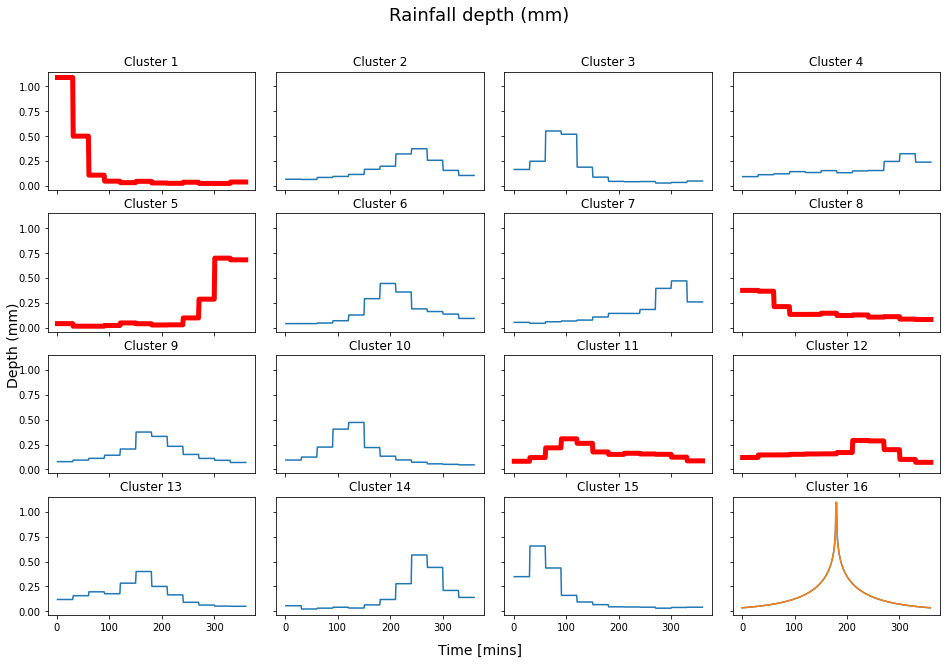

In [340]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize =(16,10), sharey=True, sharex = True)
plt.subplots_adjust(wspace=0.1)
fig.suptitle("Rainfall depth (mm)", fontsize=18, y=0.97)

clusters_and_feh_ls = clusters_rainfall_data_ls.copy()
clusters_and_feh_ls.insert(0, df)

# loop through tickers and axes
for num, clusters_rainfall_data in enumerate(clusters_and_feh_ls):
    ax = axs.ravel()[num-1]
    if num in [12,11,1,5,8]:
        ax.plot(clusters_rainfall_data['minute'], clusters_rainfall_data['rainfall_depth_this_min'], linewidth =5, color = 'red' )   
    else:
        ax.plot(clusters_rainfall_data['minute'], clusters_rainfall_data['rainfall_depth_this_min'])      
    if num == 0:
        ax.set_title("FEH profile")
    else:
        ax.set_title("Cluster {}".format(num))
fig.text(0.5, 0.07, 'Time [mins]', ha='center', fontsize =14)
fig.text(0.09, 0.5, "Depth (mm)", va='center', rotation='vertical', fontsize =14)